In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# splitting data:
from sklearn.model_selection import train_test_split

# web-based requests
import requests

# Importing the os library specifically for reading the csv once I've created the file in my working directory.
import os

import acquire
import prepare

credentials loaded successfully
End of file.


In [2]:
pd.__version__

'1.1.3'

In [3]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
70.121.214.34         2
35.175.171.137        2
52.87.230.102         2
54.145.52.184         1
52.90.165.200         1
34.229.70.250         1
97.105.15.120         1
54.172.14.223         1
35.174.209.2          1
95.31.16.121          1
3.92.201.136          1
52.91.30.150          1
3.88.129.158          1
45.23.250.16          1
95.31.18.119          1
34.207.64.242         1
Name: ip, dtype: int64

# Exercises

- Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.
- Focus on finding anomolies in `ip`, `request_method` and even `size` and `request_agent`.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [8]:
# cleaing up the datetime column by removing the brackets and replacing them with "".

df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [9]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales?page=81 HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales?page=82 HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales?page=83 HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales?page=84 HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [10]:
# Removes the detail of the page number
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [11]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [12]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


#### Finding any potential anomolies in already existing data

In [13]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})


ip_df = ip_df.merge(ip_df2)

In [14]:
ip_df.sort_values(by='ip_proba', ascending=False).head()

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


In [15]:
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,70.121.214.34,2,0.000143
7,35.175.171.137,2,0.000143
8,52.87.230.102,2,0.000143
9,54.145.52.184,1,0.000072
10,52.90.165.200,1,0.000072
11,34.229.70.250,1,0.000072
12,97.105.15.120,1,0.000072
13,54.172.14.223,1,0.000072


22
               ip  ip_count  ip_proba
12  97.105.15.120         1  0.000072
13  54.172.14.223         1  0.000072
14   35.174.209.2         1  0.000072
15   95.31.16.121         1  0.000072
16   3.92.201.136         1  0.000072
17   52.91.30.150         1  0.000072
18   3.88.129.158         1  0.000072
19   45.23.250.16         1  0.000072
20   95.31.18.119         1  0.000072
21  34.207.64.242         1  0.000072


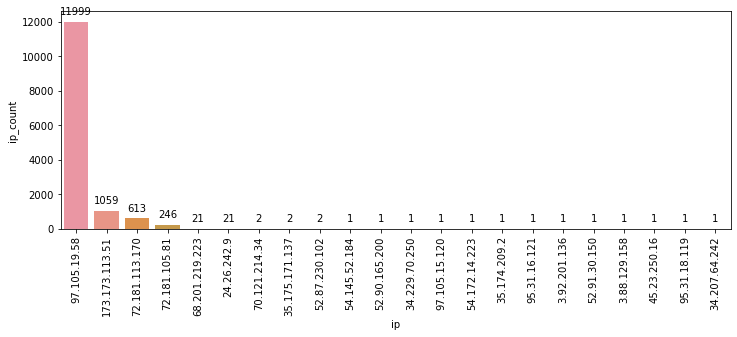

In [16]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [17]:
request_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_count'})

request_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_proba'})



In [18]:
request_df.head(2)

,request_method,request_count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065


In [19]:
request_df2.head(2)

,request_method,request_proba
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191


In [20]:
request_df = request_df.merge(request_df2)

In [21]:
request_df.head(2)

,request_method,request_count,request_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191


22
                                  request_method  request_count  request_proba
12                    GET /api/v1/store HTTP/1.1              3       0.000215
13                   GET /api/v1/sales/ HTTP/1.1              3       0.000215
14                     GET /api/v1items HTTP/1.1              2       0.000143
15        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1       0.000072
16                    GET /api/v1/items/HTTP/1.1              1       0.000072
17                          GET /api/v1 HTTP/1.1              1       0.000072
18             GET /api/v1/items&page=0 HTTP/1.1              1       0.000072
19              GET /api/v1/helloclass! HTTP/1.1              1       0.000072
20  GET /api/v1//api/v1/items/next_page HTTP/1.1              1       0.000072
21                  GET /api/V1/HiZach! HTTP/1.1              1       0.000072


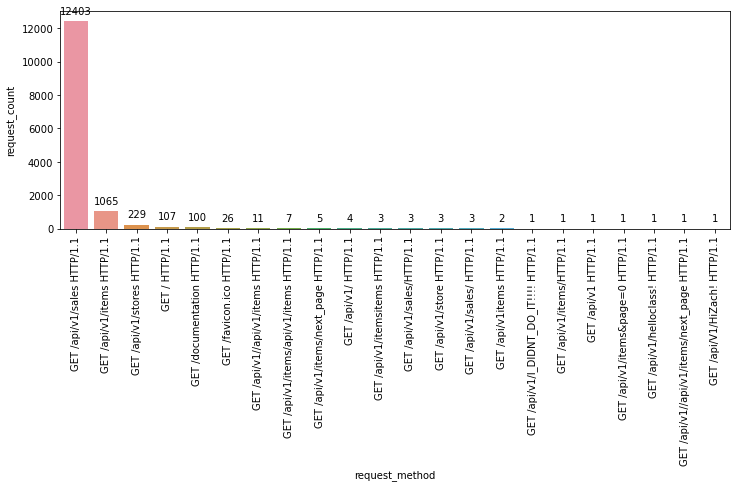

In [22]:
print(len(request_df))

print(request_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_df, x = 'request_method', y = 'request_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

#### Establishing a baseline for future datapoints:

In [24]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]
train.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [25]:
# Probability of discrete/categorical occurence
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df.head()

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,68.201.219.223,0.001503


In [26]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595


In [27]:
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

This is the point that I merge the "predictions" with all the data to see how it stacks up.

In [28]:
request_prob_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_proba'})

In [29]:
request_prob_df

,request_method,request_proba
0,GET /api/v1/sales HTTP/1.1,0.887577
1,GET /api/v1/items HTTP/1.1,0.076213
2,GET /api/v1/stores HTTP/1.1,0.016388
3,GET / HTTP/1.1,0.007657
4,GET /documentation HTTP/1.1,0.007156
5,GET /favicon.ico HTTP/1.1,0.001861
6,GET /api/v1//api/v1/items HTTP/1.1,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,0.000358
9,GET /api/v1/ HTTP/1.1,0.000286


In [30]:
# Merging the request_proba with the overall df:

df = df.reset_index().merge(request_prob_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

In [31]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,request_proba
timestamp,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.887577
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.076213
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.887577
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.887577
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.887577


In [32]:
ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )
status_given_ip

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000286
1,24.26.242.9,200,1.000286
2,3.88.129.158,200,1.000286
3,3.92.201.136,200,1.000286
4,34.207.64.242,200,1.000286
5,34.229.70.250,200,1.000286
6,35.174.209.2,200,1.000286
7,35.175.171.137,200,1.000286
8,45.23.250.16,200,1.000286
9,52.87.230.102,200,1.000286


In [33]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)
ip_status.sort_values(by="ip_status_count", ascending=False)

,ip,status,proba_status_given_ip,ip_status_count
19,97.105.19.58,200,0.999119,11984
0,173.173.113.51,200,1.000286,1059
17,72.181.113.170,200,0.997023,611
16,72.181.105.81,200,1.000286,246
1,24.26.242.9,200,1.000286,21
14,68.201.219.223,200,1.000286,21
20,97.105.19.58,499,0.001167,14
7,35.175.171.137,200,1.000286,2
9,52.87.230.102,200,1.000286,2
15,70.121.214.34,200,1.000286,2


In [34]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [35]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,request_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.887577,0.999119,11984.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.076213,0.999119,11984.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.887577,0.999119,11984.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.887577,0.999119,11984.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.887577,0.999119,11984.0


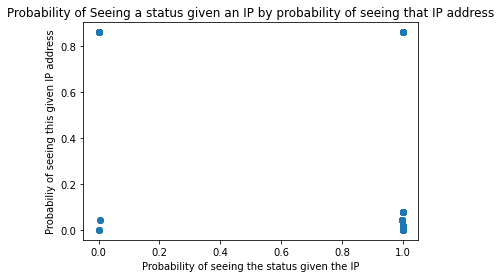

In [36]:
plt.title("Probability of Seeing a status given an IP by probability of seeing that IP address")
plt.xlabel("Probability of seeing the status given the IP")
plt.ylabel("Probabiliy of seeing this given IP address")
plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.show()

#### Probability of a Request type based on IP address:

In [37]:
request_probs = train.groupby('request_method').size().div(len(df))

In [38]:
request_given_ip = pd.DataFrame(train.groupby(['ip', 'request_method']).\
                               size().div(len(train)).\
                               div(request_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_request_given_ip'})
                              )

request_given_ip

,ip,request_method,proba_request_given_ip
0,173.173.113.51,GET / HTTP/1.1,0.009348
1,173.173.113.51,GET /api/v1/items HTTP/1.1,0.176576
2,173.173.113.51,GET /api/v1/sales HTTP/1.1,0.065729
3,173.173.113.51,GET /api/v1/stores HTTP/1.1,0.235875
4,173.173.113.51,GET /documentation HTTP/1.1,0.010003
...,...,...,...
56,97.105.19.58,GET /api/v1/store HTTP/1.1,1.000286
57,97.105.19.58,GET /api/v1/stores HTTP/1.1,0.694522
58,97.105.19.58,GET /api/v1items HTTP/1.1,0.500143
59,97.105.19.58,GET /documentation HTTP/1.1,0.930266


In [39]:
request_ip_count = pd.DataFrame(train.groupby(['ip', 'request_method'])['status'].count().reset_index().rename(index = str, columns = {'status': 'ip_request_count'}))
request_ip_count

,ip,request_method,ip_request_count
0,173.173.113.51,GET / HTTP/1.1,1
1,173.173.113.51,GET /api/v1/items HTTP/1.1,188
2,173.173.113.51,GET /api/v1/sales HTTP/1.1,815
3,173.173.113.51,GET /api/v1/stores HTTP/1.1,54
4,173.173.113.51,GET /documentation HTTP/1.1,1
...,...,...,...
56,97.105.19.58,GET /api/v1/store HTTP/1.1,3
57,97.105.19.58,GET /api/v1/stores HTTP/1.1,159
58,97.105.19.58,GET /api/v1items HTTP/1.1,1
59,97.105.19.58,GET /documentation HTTP/1.1,93


In [40]:
ip_request = request_given_ip.merge(request_ip_count)
ip_request

,ip,request_method,proba_request_given_ip,ip_request_count
0,173.173.113.51,GET / HTTP/1.1,0.009348,1
1,173.173.113.51,GET /api/v1/items HTTP/1.1,0.176576,188
2,173.173.113.51,GET /api/v1/sales HTTP/1.1,0.065729,815
3,173.173.113.51,GET /api/v1/stores HTTP/1.1,0.235875,54
4,173.173.113.51,GET /documentation HTTP/1.1,0.010003,1
...,...,...,...,...
56,97.105.19.58,GET /api/v1/store HTTP/1.1,1.000286,3
57,97.105.19.58,GET /api/v1/stores HTTP/1.1,0.694522,159
58,97.105.19.58,GET /api/v1items HTTP/1.1,0.500143,1
59,97.105.19.58,GET /documentation HTTP/1.1,0.930266,93


In [41]:
df = df.reset_index().merge(ip_request, on=['ip', 'request_method'], how='left').fillna(value=0).set_index('timestamp')

In [42]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,request_proba,proba_status_given_ip,ip_status_count,proba_request_given_ip,ip_request_count
timestamp,,,,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.887577,0.999119,11984.0,0.877861,10885.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.076213,0.999119,11984.0,0.670614,714.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.887577,0.999119,11984.0,0.877861,10885.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.887577,0.999119,11984.0,0.877861,10885.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.887577,0.999119,11984.0,0.877861,10885.0


In [43]:
request_df = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().rename(index=str, columns={'index': 'request_method', 'ip': 'request_proba'})

In [44]:
request_df

,request_method,request_method
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154
5,GET /favicon.ico HTTP/1.1,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,0.000358
9,GET /api/v1/ HTTP/1.1,0.000286


In [45]:
request_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_count'})

request_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_proba'})


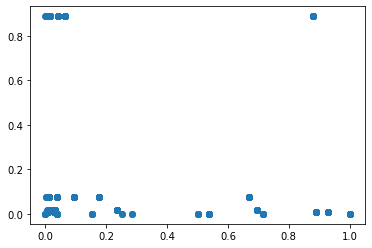

In [46]:
plt.scatter(df.proba_request_given_ip, df.request_proba)

#### Takeaways:

- Just looking at the counts of each api call, the highest call makes sense, as it has the highest number of pages (183 pages) and thus it would be a larger number of calls by far than the other pages.
- What is the `I_DIDNT_DO_IT!!!!!!!` call? Not sure what that is, but I would want to investigate more since it doesn't seem like a normal page one would see. (Although knowing this is Zach's personal website, it's just a joke) but in a "professional" environment that type of webpage would probably require additional investigation.
- Looks like the `request_method` is fairly commonly pointing towards the items and sales data, which makes sense

In [ ]:
train.destination.value_counts()

#### Probability of size by ip

In [ ]:
df.head()

In [ ]:
train.head()

In [ ]:
train.status.value_counts()

In [ ]:
size_probs = train.groupby('size_mb').size().div(len(df))
size_probs

In [ ]:
size_given_ip = pd.DataFrame(train.groupby(['ip', 'size_mb'])).size().div(len(train)).div(size_probs, axis = 0, level = 'size_mb').reset_index().rename(index = str, columns = {0: 'proba_size_given_ip'})

In [ ]:
size_ip = train.groupby(['ip', 'size_mb'])
size_ip.size()

In [ ]:
size_ip.size().div(size_probs, axis = 0, level = 'size_mb')